# **Instituto Tecnológico y de Estudios superiores de Monterrey**

## Escuela de Ingeniería y Ciencias

### Maestría en inteligencia artificial aplicada

#### Proyecto integrador

*Avance 2*

Alumnos:  
Alfonso de Lucas Espinosa - A01795118  
Pablo Andrés Estrada Flores - A01795212

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Introducción

Introducción

En este segundo avance se aborda el procesamiento y análisis de un conjunto de datos del Lenguaje de Señas Mexicano (LSM), específicamente el dataset disponible en Kaggle: https://www.kaggle.com/datasets/jhoanborges/msl-abc-v2-mexican-sign-lang-static/data. Este conjunto está compuesto por más de 280,000 imágenes estáticas de manos representando diferentes letras del alfabeto dactilológico. Es importante mencionar que este dataset no contempla las letras J, K, Ñ, Q, X y Z.

Dado el volumen considerable del dataset, el procesamiento inicial de las imágenes para la extracción de puntos clave (landmarks) se realizó de manera local utilizando la solución MediaPipe Hands. A partir de estos landmarks tridimensionales (x, y, z), se desarrolló un pipeline de ingeniería de características enfocado en representar de forma robusta la configuración espacial de la mano.

Las características extraídas incluyen: distancias entre puntas de dedos, ángulos en nudillos MCP, longitudes y curvaturas de curvas de Bézier por dedo, así como orientaciones relativas de las tangentes de dichas curvas respecto a los ejes cartesianos. Además, se calcularon curvas Bézier horizontales entre dedos para capturar relaciones de apertura y alineación.

Estas variables fueron diseñadas con el propósito de mejorar la representación geométrica de la mano, haciendo más eficiente la tarea de clasificación de letras mediante modelos de aprendizaje automático.

#### 1: Cargar los Datos CSV

Se cargan tres archivos CSV que contienen los landmarks de la mano (63 coordenadas por imagen) y la etiqueta de la letra correspondiente. Estos archivos se combinan en un solo DataFrame para formar el dataset completo con más de 276,000 muestras.

Cargando /content/drive/MyDrive/Proyecto integrador/Avance 2/lsm-abc-A_hand_landmarks.csv...
Cargando /content/drive/MyDrive/Proyecto integrador/Avance 2/lsm-abc-B_hand_landmarks.csv...
Cargando /content/drive/MyDrive/Proyecto integrador/Avance 2/lsm-abc-C_hand_landmarks.csv...

Dataset completo cargado a partir de 3 archivo(s).
Total de muestras: 276153

Primeras 5 filas del dataset:
        x_0       y_0       z_0       x_1       y_1       z_1       x_2  \
0  0.633192  0.616210 -0.000001  0.476265  0.552617 -0.028946  0.344844   
1  0.703166  0.712390 -0.000001  0.550880  0.653267 -0.030761  0.417509   
2  0.716326  0.728844 -0.000001  0.562685  0.679250 -0.032551  0.426576   
3  0.712429  0.737260 -0.000001  0.554863  0.684339 -0.035221  0.418647   
4  0.715901  0.735214 -0.000001  0.556894  0.683482 -0.031995  0.420028   

        y_2       z_2       x_3  ...      x_18      y_18      z_18      x_19  \
0  0.416290 -0.034224  0.251013  ...  0.688139  0.175325 -0.058961  0.679427   
1

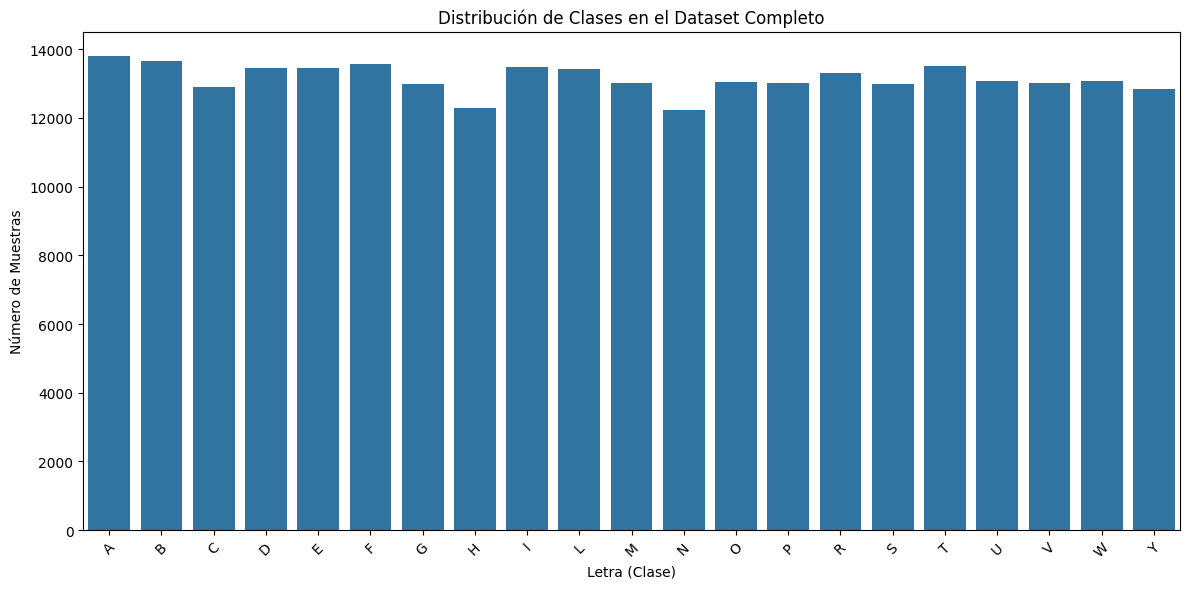

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns # Para visualizaciones un poco más estéticas
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE # Importar t-SNE


base_path = '/content/drive/MyDrive/Proyecto integrador/Avance 2'

csv_files = {
    'A': os.path.join(base_path, 'lsm-abc-A_hand_landmarks.csv'),
    'B': os.path.join(base_path, 'lsm-abc-B_hand_landmarks.csv'),
    'C': os.path.join(base_path, 'lsm-abc-C_hand_landmarks.csv')
}

# Cargar y concatenar los DataFrames
all_dataframes = []
loaded_files_count = 0
for key, file_path in csv_files.items():
    if os.path.exists(file_path):
        print(f"Cargando {file_path}...")
        try:
            df = pd.read_csv(file_path)
            all_dataframes.append(df)
            loaded_files_count += 1
        except Exception as e:
            print(f"  Error al cargar {file_path}: {e}")
    else:
        print(f"Advertencia: Archivo {file_path} no encontrado. Se omitirá.")

if not all_dataframes:
    print("Error Fatal: No se cargó ningún archivo CSV. Verifica las rutas y nombres en `base_path` y `csv_files`.")
else:
    full_df = pd.concat(all_dataframes, ignore_index=True)
    print(f"\nDataset completo cargado a partir de {loaded_files_count} archivo(s).")
    print(f"Total de muestras: {len(full_df)}")
    print("\nPrimeras 5 filas del dataset:")
    print(full_df.head())
    print("\nInformación del DataFrame:")
    full_df.info()
    print("\nEstadísticas descriptivas de las coordenadas (ejemplo para x_0, y_0, z_0):")
    if all(coord in full_df.columns for coord in ['x_0', 'y_0', 'z_0']):
        print(full_df[['x_0', 'y_0', 'z_0']].describe())
    else:
        print("Columnas x_0, y_0, o z_0 no encontradas para descripción.")
    print("\nConteo de muestras por etiqueta (clase):")
    label_counts = full_df['label'].value_counts().sort_index()
    print(label_counts)

    # Visualización del balance de clases
    plt.figure(figsize=(12, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title('Distribución de Clases en el Dataset Completo')
    plt.xlabel('Letra (Clase)')
    plt.ylabel('Número de Muestras')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### 2: Preparación de Datos (Separar Features y Labels)

Se resta la posición del landmark 0 (muñeca) a todos los demás puntos para centrar la mano. Luego, se escalan los puntos restantes dividiendo por la distancia promedio desde cada landmark al centro, con el objetivo de normalizar el tamaño de la mano.

In [ ]:
if 'full_df' in locals() and not full_df.empty:
    labels_series = full_df['label'].copy()
    landmarks_raw_np = full_df.iloc[:, :-1].values # (N, 63)

    print("Forma original de landmarks (X_raw):", landmarks_raw_np.shape)
    print("Forma original de etiquetas (y):", labels_series.shape)

    # --- Normalización Relativa a la Muñeca (Landmark 0) ---
    # El landmark 0 tiene coordenadas x_0, y_0, z_0 (índices 0, 1, 2 en cada fila)
    print("\nNormalizando landmarks respecto a la muñeca (landmark 0)...")

    # Crear una copia para no modificar el original directamente si se quiere re-ejecutar
    landmarks_normalized_np = landmarks_raw_np.copy()

    # Obtener coordenadas de la muñeca para cada muestra
    wrist_coords = landmarks_normalized_np[:, 0:3] # Shape (N, 3)

    # Iterar por los 21 landmarks y restar las coordenadas de la muñeca
    for i in range(21): # Para cada landmark (0 a 20)
        start_idx = i * 3
        # Restar x_muñeca, y_muñeca, z_muñeca
        landmarks_normalized_np[:, start_idx : start_idx+3] -= wrist_coords



    # Después de centrar, el landmark 0 (muñeca) es (0,0,0), así que no contribuye a la norma promedio.
    # Consideramos los otros 20 landmarks (índices 3 a 62)
    other_landmarks = landmarks_normalized_np[:, 3:] # Todos excepto la muñeca

    # Calculamos la norma L2 de las coordenadas (x,y,z) de cada uno de los 20 landmarks
    # other_landmarks_reshaped tiene shape (N, 20, 3)
    other_landmarks_reshaped = other_landmarks.reshape(landmarks_normalized_np.shape[0], 20, 3)

    # dist_from_wrist tiene shape (N, 20) - norma L2 de cada landmark relativo a la muñeca
    dist_from_wrist = np.linalg.norm(other_landmarks_reshaped, axis=2)

    # avg_scale_factor tiene shape (N,) - distancia promedio de los landmarks a la muñeca
    # Añadimos epsilon para evitar división por cero si todos los landmarks estuvieran en la muñeca (improbable)
    avg_scale_factor = np.mean(dist_from_wrist, axis=1) + 1e-6

    # Dividir cada coordenada de los 20 landmarks (no la muñeca) por este factor de escala
    # El factor de escala es (N,), necesitamos que sea (N,1) para broadcasting con (N, 60)
    # o (N, 20, 1) para broadcasting con (N, 20, 3)
    landmarks_normalized_np[:, 3:] /= avg_scale_factor[:, np.newaxis] # Broadcasting

    print("Landmarks normalizados respecto a la muñeca y escala.")
    print("Ejemplo del primer vector de landmarks normalizado (los 3 primeros valores deberían ser ~0):")
    print(landmarks_normalized_np[0])

    # Usaremos estos landmarks normalizados para la extracción de características
    landmarks_to_process_np = landmarks_normalized_np

else:
    print("Error: full_df no está definido o está vacío. Ejecuta la celda anterior.")

Forma original de landmarks (X_raw): (276153, 63)
Forma original de etiquetas (y): (276153,)

Normalizando landmarks respecto a la muñeca (landmark 0)...
Landmarks normalizados respecto a la muñeca y escala.
Ejemplo del primer vector de landmarks normalizado (los 3 primeros valores deberían ser ~0):
[ 0.          0.          0.          0.81961805  0.95101406 -0.04981479
  0.59345229  0.71640574 -0.05889631  0.43197473  0.53761444 -0.08358626
  0.26830832  0.48669528 -0.09098793  0.67877311  0.49106663  0.07634609
  0.65090786  0.27325973 -0.03666346  0.72148968  0.42948708 -0.10967234
  0.73025546  0.54417859 -0.14012817  0.83476791  0.45049686  0.0545907
  0.82418353  0.25171117 -0.05845911  0.87872421  0.46837641 -0.10224019
  0.85200026  0.56065968 -0.10399979  1.00159826  0.44398979  0.00893036
  0.99634487  0.24650624 -0.10637557  1.0283735   0.45953595 -0.08155677
  1.00671072  0.56740862 -0.03231941  1.16544798  0.46457491 -0.04272234
  1.18423824  0.30172179 -0.10146719  1.169

#### 3: Definición de Funciones de Ingeniería de Características

Se definen funciones para:

- Calcular distancias euclidianas entre puntos.

- Calcular ángulos entre tres puntos (por ejemplo, en nudillos).

- Generar curvas de Bézier a partir de secuencias de cuatro puntos.

- Calcular la longitud, curvatura y rotación de curvas de Bézier.

Estas funciones permiten describir la geometría y forma de la mano más allá de las coordenadas crudas.

In [ ]:
# --- Funciones Auxiliares Geométricas ---
def calculate_distance(landmarks_data, lm_id1, lm_id2):
    idx1_start = lm_id1 * 3; idx2_start = lm_id2 * 3
    coords1 = landmarks_data[:, idx1_start : idx1_start + 3]
    coords2 = landmarks_data[:, idx2_start : idx2_start + 3]
    squared_diff = (coords2 - coords1) ** 2
    sum_squared_diff = squared_diff.sum(axis=1)
    distances = np.sqrt(sum_squared_diff + 1e-6) # Epsilon para evitar sqrt(0)
    return distances.reshape(-1, 1)

def calculate_angle(landmarks_data, lm_id_a, lm_id_b, lm_id_c):
    idx_a_start=lm_id_a*3; idx_b_start=lm_id_b*3; idx_c_start=lm_id_c*3
    coords_a=landmarks_data[:, idx_a_start:idx_a_start+3]
    coords_b=landmarks_data[:, idx_b_start:idx_b_start+3]
    coords_c=landmarks_data[:, idx_c_start:idx_c_start+3]
    vector_ba = coords_a - coords_b; vector_bc = coords_c - coords_b
    dot_product = np.sum(vector_ba * vector_bc, axis=1)
    norm_ba = np.linalg.norm(vector_ba, axis=1)
    norm_bc = np.linalg.norm(vector_bc, axis=1)
    denominator = (norm_ba * norm_bc) + 1e-6 # Epsilon
    cos_angle = dot_product / denominator
    cos_angle_clipped = np.clip(cos_angle, -1.0, 1.0)
    angle_radians = np.arccos(cos_angle_clipped)
    return angle_radians.reshape(-1, 1)

def calculate_vector_angle(vec1, vec2):
    if vec2.ndim == 1: vec2 = vec2[np.newaxis, :] # Broadcast si vec2 es un solo vector (eje)
    dot_product = np.sum(vec1 * vec2, axis=1)
    norm1 = np.linalg.norm(vec1, axis=1)
    norm2 = np.linalg.norm(vec2, axis=1)
    denominator = (norm1 * norm2) + 1e-9 # Epsilon más pequeño
    cos_angle = dot_product / denominator
    cos_angle_clipped = np.clip(cos_angle, -1.0, 1.0)
    angle_radians = np.arccos(cos_angle_clipped)
    return angle_radians.reshape(-1, 1)

# --- Funciones Bézier ---
def get_bezier_points(p0, p1, p2, p3, t):
    N = p0.shape[0]; num_t = t.shape[0]; t_exp = t[np.newaxis, :]
    p0_exp,p1_exp,p2_exp,p3_exp = [p[:, np.newaxis, :] for p in [p0,p1,p2,p3]]
    c0=(1 - t_exp)**3; c1=3*(1-t_exp)**2*t_exp; c2=3*(1-t_exp)*t_exp**2; c3=t_exp**3
    curve_points = c0[...,np.newaxis]*p0_exp + c1[...,np.newaxis]*p1_exp + \
                   c2[...,np.newaxis]*p2_exp + c3[...,np.newaxis]*p3_exp
    return curve_points

def bezier_curve_length(p0, p1, p2, p3, num_steps=10):
    t_values = np.linspace(0, 1, num_steps)
    curve_points = get_bezier_points(p0, p1, p2, p3, t_values)
    diffs = curve_points[:, 1:, :] - curve_points[:, :-1, :]
    segment_lengths = np.sqrt(np.sum(diffs**2, axis=2) + 1e-6)
    total_lengths = np.sum(segment_lengths, axis=1)
    return total_lengths.reshape(-1, 1)

def bezier_first_derivative(p0, p1, p2, p3, t):
    N=p0.shape[0]; num_t=t.shape[0]; t_exp=t[np.newaxis, :]
    p0_exp,p1_exp,p2_exp,p3_exp=[p[:,np.newaxis,:] for p in [p0,p1,p2,p3]]
    c0_prime=3*(1-t_exp)**2; c1_prime=6*(1-t_exp)*t_exp; c2_prime=3*t_exp**2
    term1=c0_prime[...,np.newaxis]*(p1_exp-p0_exp)
    term2=c1_prime[...,np.newaxis]*(p2_exp-p1_exp)
    term3=c2_prime[...,np.newaxis]*(p3_exp-p2_exp)
    derivative = term1 + term2 + term3
    return derivative

def bezier_second_derivative(p0, p1, p2, p3, t):
    N=p0.shape[0]; num_t=t.shape[0]; t_exp=t[np.newaxis, :]
    p0_exp,p1_exp,p2_exp,p3_exp=[p[:,np.newaxis,:] for p in [p0,p1,p2,p3]]
    c0_double_prime=6*(1-t_exp); c1_double_prime=6*t_exp
    term1=c0_double_prime[...,np.newaxis]*(p2_exp-2*p1_exp+p0_exp)
    term2=c1_double_prime[...,np.newaxis]*(p3_exp-2*p2_exp+p1_exp)
    second_derivative = term1 + term2
    return second_derivative

def calculate_bezier_curvature(p0, p1, p2, p3, t):
    if not isinstance(t, np.ndarray): t = np.array([t])
    elif t.ndim == 0: t = t.reshape(1)
    b_prime = bezier_first_derivative(p0, p1, p2, p3, t)
    b_double_prime = bezier_second_derivative(p0, p1, p2, p3, t)
    cross_prod = np.cross(b_prime, b_double_prime, axis=2)
    norm_cross_prod = np.linalg.norm(cross_prod, axis=2)
    norm_b_prime = np.linalg.norm(b_prime, axis=2)
    denominator = norm_b_prime**3 + 1e-9 # Epsilon para evitar división por cero
    curvature = norm_cross_prod / denominator
    if curvature.shape[1] == 1: return curvature # Si t era un escalar, devuelve (N,1)
    else: return curvature # Si t era un array, devuelve (N, num_t)

# --- Función Principal  ---
def extract_features(landmarks_data_input):
    """
    Toma landmarks (N, 63) y devuelve features (N, 37).
    Adaptada para tomar directamente el array de landmarks_np.
    Incluye prints para describir cada grupo de características.
    """
    if landmarks_data_input.ndim == 1:
        landmarks_data = landmarks_data_input.reshape(1, -1)
    elif landmarks_data_input.shape[1] != 63:
        print(f"Error: Se esperan 63 coords, se recibieron {landmarks_data_input.shape[1]}", file=sys.stderr)
        return None
    else:
        landmarks_data = landmarks_data_input

    print(f"\n  Aplicando ingeniería de características a datos con shape: {landmarks_data.shape}")
    all_features = []

    # --- 1. Características Geométricas (8 features) ---
    print("    Calculando 1. Características Geométricas:")
    # Distancias entre Puntas (4 features)
    print("      - Distancias entre puntas de dedos (4 features)...")
    dist_thumb_index = calculate_distance(landmarks_data, 4, 8)
    dist_index_middle = calculate_distance(landmarks_data, 8, 12)
    dist_middle_ring = calculate_distance(landmarks_data, 12, 16)
    dist_ring_pinky = calculate_distance(landmarks_data, 16, 20)
    all_features.extend([dist_thumb_index, dist_index_middle, dist_middle_ring, dist_ring_pinky])

    # Ángulos de Nudillo MCP (4 features)
    print("      - Ángulos de nudillos MCP (4 features)...")
    angle_index_mcp = calculate_angle(landmarks_data, 0, 5, 8)
    angle_middle_mcp = calculate_angle(landmarks_data, 0, 9, 12)
    angle_ring_mcp = calculate_angle(landmarks_data, 0, 13, 16)
    angle_pinky_mcp = calculate_angle(landmarks_data, 0, 17, 20)
    all_features.extend([angle_index_mcp, angle_middle_mcp, angle_ring_mcp, angle_pinky_mcp])

    # --- 2. Características Bézier Verticales (Dedos) ---
    print("    Calculando 2. Características Bézier Verticales (Dedos):")
    finger_definitions = {
        'thumb': [1, 2, 3, 4], 'index': [5, 6, 7, 8], 'middle': [9, 10, 11, 12],
        'ring': [13, 14, 15, 16], 'pinky': [17, 18, 19, 20]
    }
    bezier_vertical_lengths_list = []
    bezier_vertical_curvatures_list = []
    bezier_vertical_rotation_list = []

    axis_x = np.array([1.0, 0.0, 0.0])
    axis_y = np.array([0.0, 1.0, 0.0])
    axis_z = np.array([0.0, 0.0, 1.0])

    # Longitudes Verticales (5 features)
    print("      - Longitudes de curvas Bézier de dedos (5 features)...")
    for finger_name, lm_ids in finger_definitions.items():
        p_idx = [lm_id * 3 for lm_id in lm_ids]
        p0,p1,p2,p3 = [landmarks_data[:,i:i+3] for i in p_idx]
        bezier_vertical_lengths_list.append(bezier_curve_length(p0, p1, p2, p3))
    if bezier_vertical_lengths_list: all_features.extend(bezier_vertical_lengths_list)

    # Curvaturas Verticales (5 features)
    print("      - Curvaturas de curvas Bézier de dedos (en t=0.5) (5 features)...")
    for finger_name, lm_ids in finger_definitions.items():
        p_idx = [lm_id * 3 for lm_id in lm_ids]
        p0,p1,p2,p3 = [landmarks_data[:,i:i+3] for i in p_idx]
        bezier_vertical_curvatures_list.append(calculate_bezier_curvature(p0, p1, p2, p3, t=0.5))
    if bezier_vertical_curvatures_list: all_features.extend(bezier_vertical_curvatures_list)

    # Rotaciones Verticales (15 features)
    print("      - Ángulos de rotación de tangentes Bézier de dedos (vs X,Y,Z en t=0.5) (15 features)...")
    for finger_name, lm_ids in finger_definitions.items():
        p_idx = [lm_id * 3 for lm_id in lm_ids]
        p0,p1,p2,p3 = [landmarks_data[:,i:i+3] for i in p_idx]
        tangent_mid = bezier_first_derivative(p0,p1,p2,p3,np.array([0.5])).squeeze(axis=1)
        bezier_vertical_rotation_list.extend([calculate_vector_angle(tangent_mid, axis_x),
                                             calculate_vector_angle(tangent_mid, axis_y),
                                             calculate_vector_angle(tangent_mid, axis_z)])
    if bezier_vertical_rotation_list: all_features.extend(bezier_vertical_rotation_list)

    # --- 3. Características Bézier Horizontales (Entre Dedos) ---
    print("    Calculando 3. Características Bézier Horizontales (Entre Dedos):")
    horizontal_definitions = {
        'tips': [8, 12, 16, 20],  # Index(P0)-Middle(P1)-Ring(P2)-Pinky(P3)
        'dips': [7, 11, 15, 19],
        'pips': [6, 10, 14, 18],
        'mcps': [5, 9, 13, 17]
    }
    bezier_horizontal_lengths_list = []
    # (Aquí podrías añadir listas para curvatura y rotación horizontal si las implementas)

    # Longitudes Horizontales (4 features)
    print("      - Longitudes de curvas Bézier horizontales (4 features)...")
    for level_name, lm_ids in horizontal_definitions.items():
        p_idx = [lm_id * 3 for lm_id in lm_ids]
        p0,p1,p2,p3 = [landmarks_data[:,i:i+3] for i in p_idx]
        bezier_horizontal_lengths_list.append(bezier_curve_length(p0,p1,p2,p3))
    if bezier_horizontal_lengths_list: all_features.extend(bezier_horizontal_lengths_list)

    # (Aquí iría el cálculo de curvatura y rotación horizontal si se añaden)

    if not all_features: return None
    final_features = np.hstack(all_features)
    print(f"  Shape de características finales resultante: {final_features.shape} (Total: {final_features.shape[1]} features)")
    return final_features

print("Funciones de ingeniería de características definidas con descripciones.")

Funciones de ingeniería de características definidas con descripciones.


#### 4: Aplicar la Extracción de Características

Se aplica la ingeniería de características a los landmarks normalizados. El resultado son 37 variables por imagen, agrupadas en:

- 4 distancias entre puntas de dedos.

- 4 ángulos en nudillos MCP.

- 5 longitudes de curvas Bézier (uno por dedo).

- 5 curvaturas de curvas Bézier (uno por dedo).

- 15 ángulos entre tangente de la curva Bézier y los ejes X, Y, Z (tres por dedo).

- 4 longitudes de curvas Bézier horizontales entre dedos.

In [ ]:
if 'landmarks_to_process_np' in locals() and 'labels_series' in locals():
    # Aplicar la extracción a todos los landmarks normalizados
    X_features = extract_features(landmarks_to_process_np)

    if X_features is not None:
        print("\nExtracción de 37 características completada.")
        print("Shape de X_features:", X_features.shape)
        print("Shape de labels:", labels_series.shape)
    else:
        print("Error durante la extracción de características.")
else:
    print("Error: landmarks_to_process_np o labels_series no están definidos. Ejecuta la Celda 2.")


  Aplicando ingeniería de características a datos con shape: (276153, 63)
    Calculando 1. Características Geométricas:
      - Distancias entre puntas de dedos (4 features)...
      - Ángulos de nudillos MCP (4 features)...
    Calculando 2. Características Bézier Verticales (Dedos):
      - Longitudes de curvas Bézier de dedos (5 features)...
      - Curvaturas de curvas Bézier de dedos (en t=0.5) (5 features)...
      - Ángulos de rotación de tangentes Bézier de dedos (vs X,Y,Z en t=0.5) (15 features)...
    Calculando 3. Características Bézier Horizontales (Entre Dedos):
      - Longitudes de curvas Bézier horizontales (4 features)...
  Shape de características finales resultante: (276153, 37) (Total: 37 features)

Extracción de 37 características completada.
Shape de X_features: (276153, 37)
Shape de labels: (276153,)


#### 5: Visualización y Análisis Exploratorio de las Características

Se escalan las 37 características con StandardScaler para garantizar que todas tengan media 0 y desviación estándar 1, lo cual es crucial para métodos como PCA o t-SNE. Las etiquetas se codifican a valores numéricos con LabelEncoder para facilitar el modelado y análisis. Se genera un nuevo DataFrame que incluye tanto las características escaladas como las etiquetas en formato string y numérico, listo para visualizaciones y modelos de clasificación.

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# LabelEncoder ya debería estar importado, pero por si acaso.

if 'X_features' in locals() and 'labels_series' in locals():
    scaler_all = StandardScaler()
    X_features_scaled = scaler_all.fit_transform(X_features)
    print("Todas las 37 características han sido escaladas para análisis/modelado.")

    # Codificar etiquetas string a numéricas para t-SNE/PCA y futuro modelado
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels_series)

    # Crear DataFrame para visualizaciones
    feature_names_37 = [f"feature_{i}" for i in range(X_features_scaled.shape[1])]
    features_37_df = pd.DataFrame(X_features_scaled, columns=feature_names_37)
    features_37_df['label_encoded'] = y_encoded # Usar numéricas para PCA/t-SNE
    features_37_df['label_str'] = labels_series # String para ejes de gráficos

    print("\nPrimeras filas del DataFrame de 37 características escaladas con etiquetas:")
    print(features_37_df.head())
else:
    print("Error: X_features o labels_series no definidos. Ejecuta la celda anterior.")

Todas las 37 características han sido escaladas para análisis/modelado.

Primeras filas del DataFrame de 37 características escaladas con etiquetas:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.538327  -0.466134  -0.301194  -0.227015   0.862543   0.760331   
1   0.093865  -0.531798  -0.439015  -0.432839   0.970172   0.932958   
2   0.077431  -0.560991  -0.463200  -0.440382   1.033028   1.039969   
3   0.177720  -0.591962  -0.445197  -0.420448   0.946933   0.930721   
4   0.133096  -0.571686  -0.450508  -0.417647   0.939833   0.942761   

   feature_6  feature_7  feature_8  feature_9  ...  feature_29  feature_30  \
0   0.852388   0.453413   3.065224  -0.238983  ...   -0.257376   -0.324285   
1   1.039017   0.499316   1.735032  -0.791347  ...   -0.360951   -0.266405   
2   1.235353   0.701793   1.463690  -0.913691  ...   -0.408430   -0.403504   
3   1.229035   0.754947   1.589017  -0.794246  ...   -0.326158   -0.405722   
4   1.217840   0.667005   1.508714

#### 6: Visualización y Análisis

Se realizan múltiples visualizaciones para entender el comportamiento de las características:

- Un histograma muestra la distribución de una característica individual (por ejemplo, la distancia pulgar-índice).

- Un boxplot muestra cómo varía esa característica entre diferentes letras.

- Una matriz de correlación ayuda a identificar relaciones lineales entre las primeras 15 características.

- Se aplica PCA para reducir la dimensionalidad a 2 componentes y visualizar las clases en 2D, mostrando qué tan separables son.

- Finalmente, se aplica t-SNE, una técnica no lineal de reducción de dimensiones, para visualizar de manera más precisa las agrupaciones de las letras en un espacio bidimensional. Se toma una muestra para acelerar el proceso si el conjunto es muy grande.


--- Iniciando Visualización Avanzada de Características ---


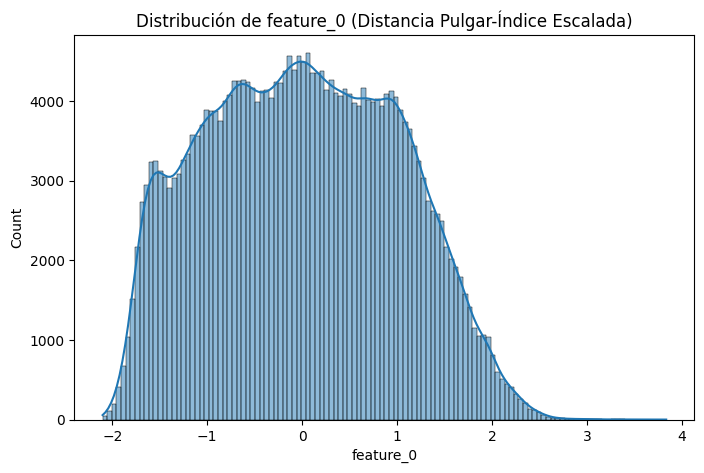

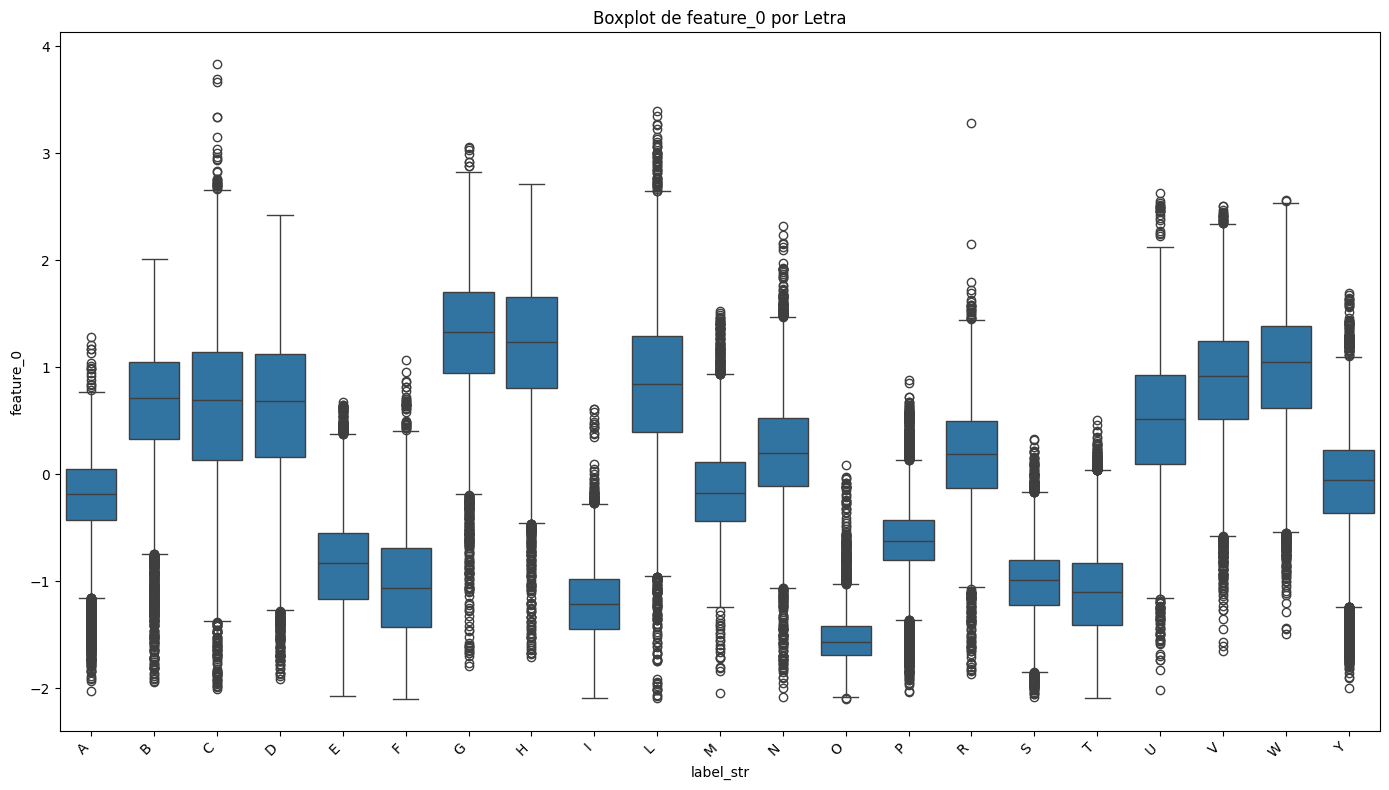

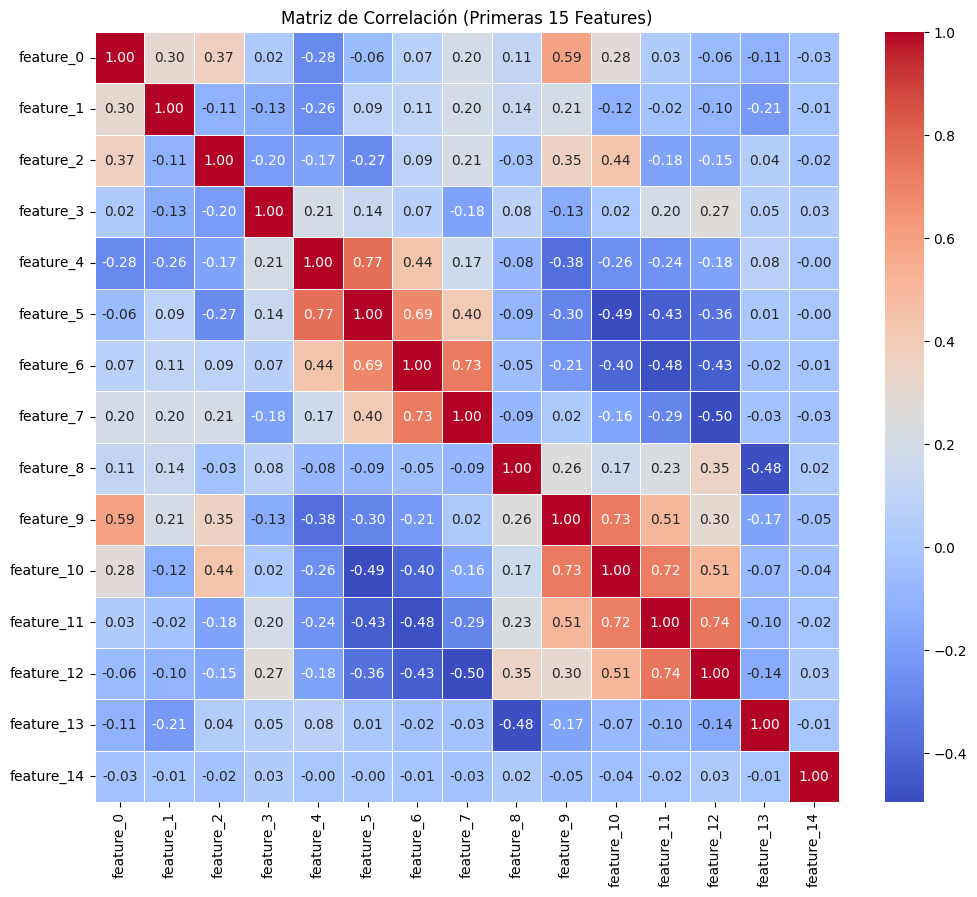


Calculando PCA...
Varianza explicada por los 2 componentes principales: 31.39%


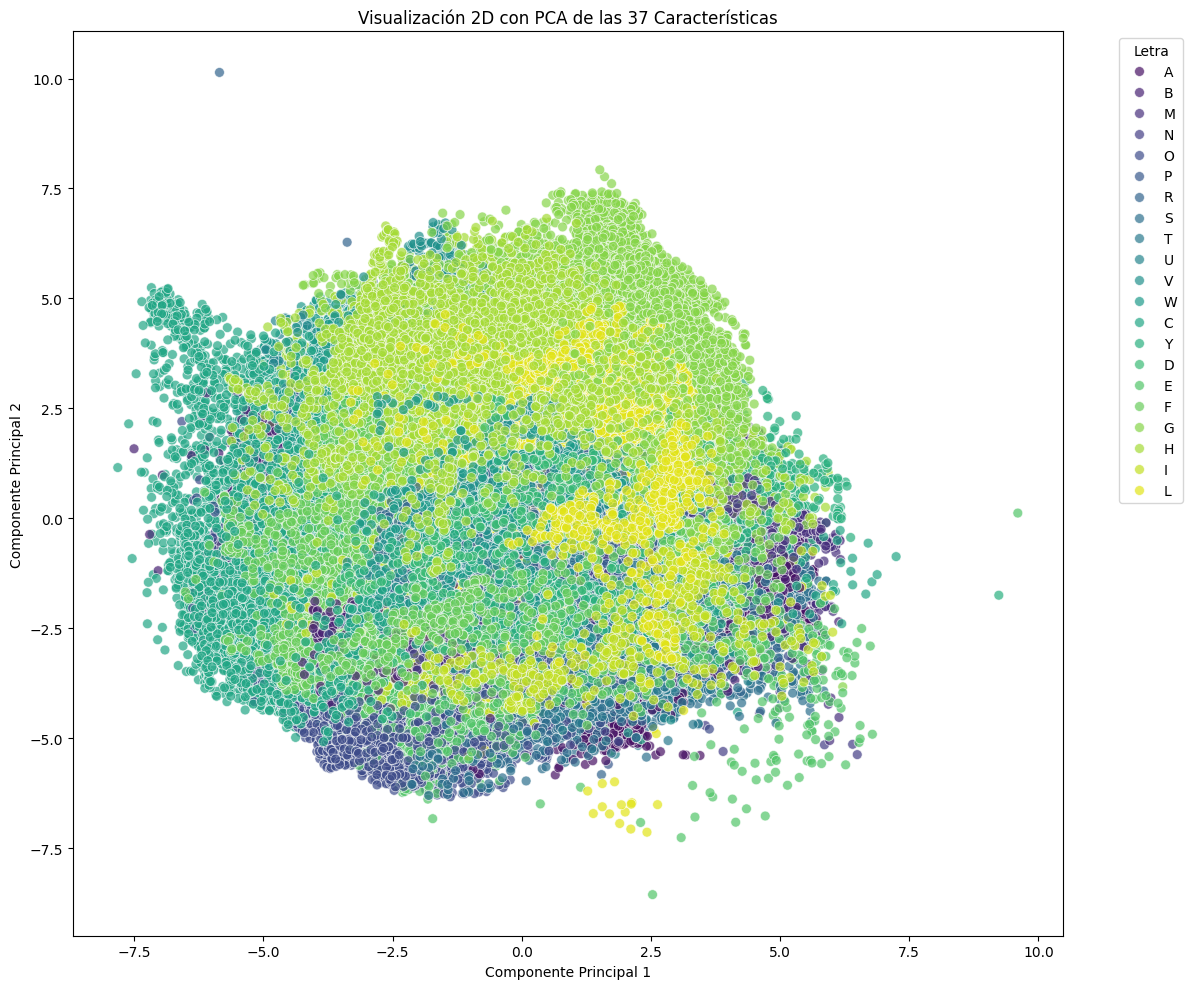


Calculando t-SNE... (Esto puede tardar varios minutos en datasets grandes)
  Tomando una muestra de 180000 para t-SNE para acelerar...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 180000 samples in 0.009s...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 180000 samples in 278.374s...
[t-SNE] Computed conditional probabilities for sample 1000 / 180000
[t-SNE] Computed conditional probabilities for sample 2000 / 180000
[t-SNE] Computed conditional probabilities for sample 3000 / 180000
[t-SNE] Computed conditional probabilities for sample 4000 / 180000
[t-SNE] Computed conditional probabilities for sample 5000 / 180000
[t-SNE] Computed conditional probabilities for sample 6000 / 180000
[t-SNE] Computed conditional probabilities for sample 7000 / 180000
[t-SNE] Computed conditional probabilities for sample 8000 / 180000
[t-SNE] Computed conditional probabilities for sample 9000 / 180000
[t-SNE] Computed conditional probabilities for sample 10000 / 180000
[t-SNE] Computed conditional probabilities for sample 11000 / 180000
[t-SNE] Computed conditional probabilities for sample 12000 / 180000
[t-SNE] Computed conditional probabilities for sample 13000 / 180000
[t-SNE] Computed conditional probabilities for samp

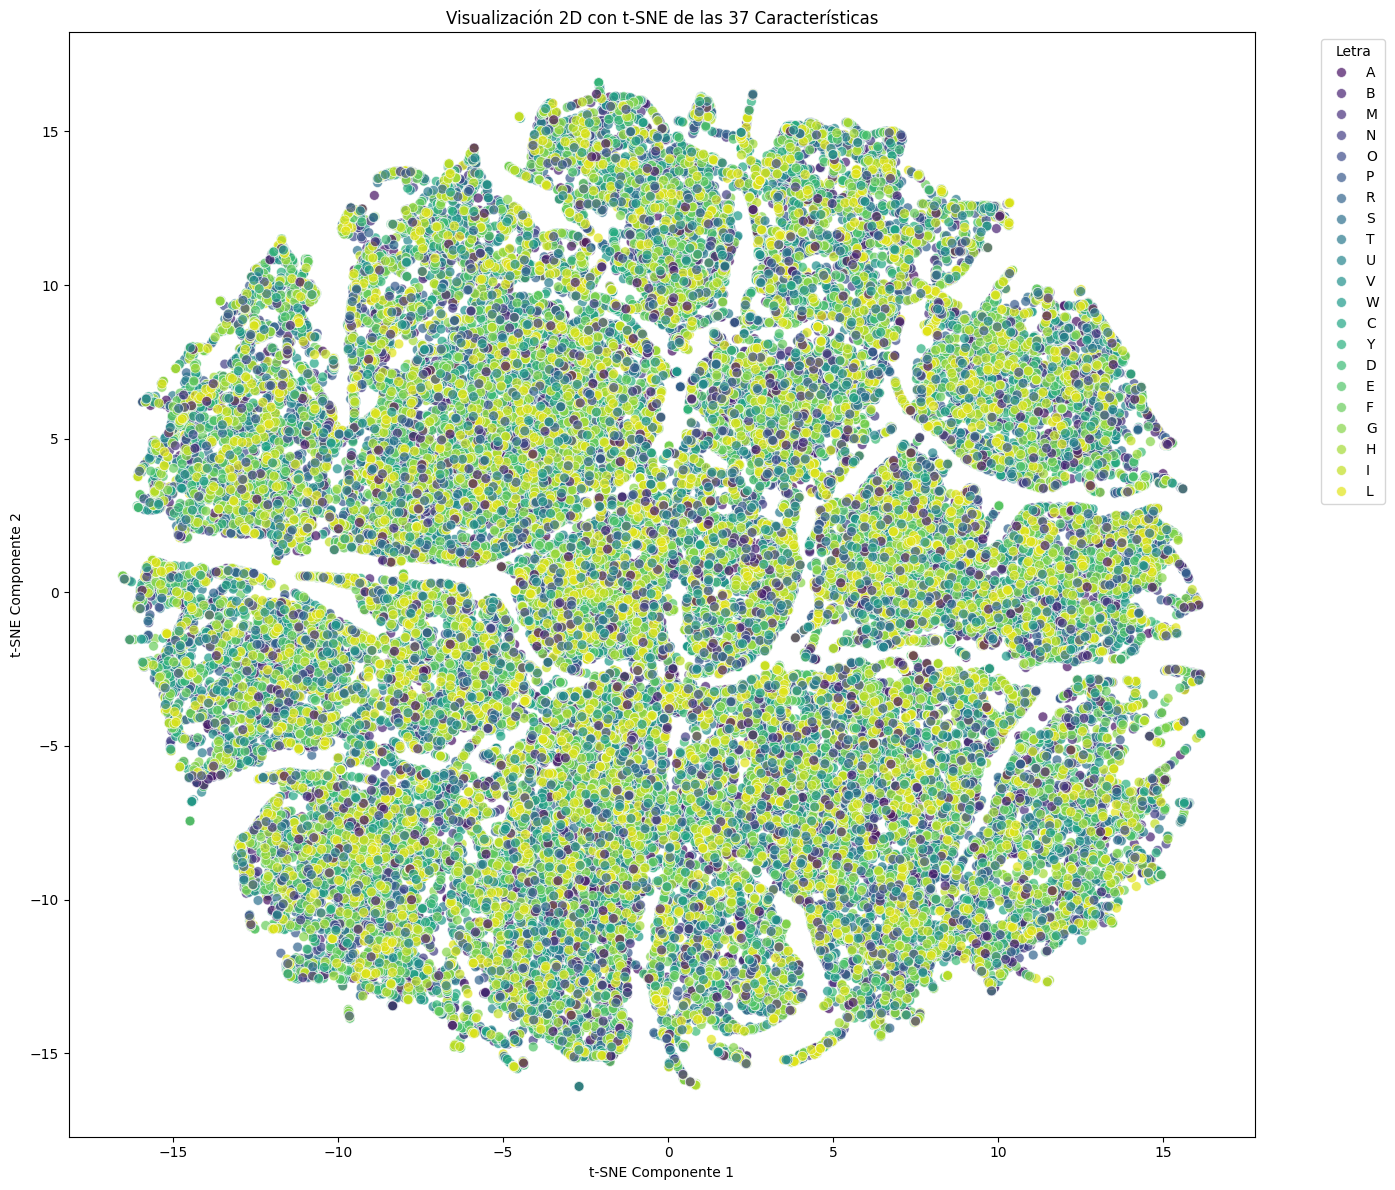

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

if 'features_37_df' in locals():
    print("\n--- Iniciando Visualización Avanzada de Características ---")

    # 1. Histograma de una característica (ej. la primera, feature_0)
    plt.figure(figsize=(8, 5))
    sns.histplot(data=features_37_df, x='feature_0', kde=True)
    plt.title('Distribución de feature_0 (Distancia Pulgar-Índice Escalada)')
    plt.show()

    # 2. Boxplot de una característica por clase (ej. feature_0)
    plt.figure(figsize=(14, 8))
    sorted_unique_labels_str = sorted(features_37_df['label_str'].unique())
    sns.boxplot(data=features_37_df, x='label_str', y='feature_0', order=sorted_unique_labels_str)
    plt.title('Boxplot de feature_0 por Letra')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 3. Matriz de Correlación (Primeras 15 features para legibilidad)
    num_corr_features = 15
    plt.figure(figsize=(12, 10))
    correlation_matrix = features_37_df[[f'feature_{i}' for i in range(num_corr_features)]].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Matriz de Correlación (Primeras {num_corr_features} Features)')
    plt.show()

    # 4. Análisis de Componentes Principales (PCA)
    print("\nCalculando PCA...")
    pca = PCA(n_components=2) # Reducir a 2 componentes para visualización
    X_pca = pca.fit_transform(X_features_scaled) # Usar datos escalados
    print(f"Varianza explicada por los 2 componentes principales: {pca.explained_variance_ratio_.sum()*100:.2f}%")

    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['label_str'] = features_37_df['label_str'] # Añadir etiquetas string para el gráfico

    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='PC1', y='PC2', hue='label_str', data=pca_df, palette='viridis', s=50, alpha=0.7)
    plt.title('Visualización 2D con PCA de las 37 Características')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(title='Letra', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 5. t-SNE
    print("\nCalculando t-SNE... (Esto puede tardar varios minutos en datasets grandes)")
    n_tsne_samples = 180000
    if X_features_scaled.shape[0] > n_tsne_samples:
        print(f"  Tomando una muestra de {n_tsne_samples} para t-SNE para acelerar...")
        sample_indices = np.random.choice(X_features_scaled.shape[0], n_tsne_samples, replace=False)
        X_tsne_input = X_features_scaled[sample_indices]
        y_tsne_labels = features_37_df['label_str'].iloc[sample_indices]
    else:
        X_tsne_input = X_features_scaled
        y_tsne_labels = features_37_df['label_str']

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300, verbose=1)
    X_tsne = tsne.fit_transform(X_tsne_input)

    tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
    tsne_df['label_str'] = y_tsne_labels

    plt.figure(figsize=(14, 12))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='label_str', data=tsne_df, palette='viridis', s=50, alpha=0.7)
    plt.title('Visualización 2D con t-SNE de las 37 Características')
    plt.xlabel('t-SNE Componente 1')
    plt.ylabel('t-SNE Componente 2')
    plt.legend(title='Letra', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("Error: features_37_df no definido. Ejecuta la celda anterior.")

#### Conclusiones



1.   El análisis univariante de la característica feature_0 (Distancia Pulgar-Índice), tras la aplicación de StandardScaler, revela una distribución aproximadamente normal, como se evidencia en su histograma. Esto sugiere que el preprocesamiento de escalado ha sido efectivo para esta variable, preparándola adecuadamente para el modelado.
2.   El análisis bivariado mediante boxplots, ejemplificado con feature_0 (Distancia Pulgar-Índice Escalada), revela diferencias notables en la distribución de esta característica entre las distintas letras del alfabeto. No obstante, el solapamiento existente entre las distribuciones de otras clases indica que, si bien es informativa, se requiere un conjunto más amplio de características para una separación completa y robusta de todas las señas, es por ello que se tiene 37 características de refuerzo para el análisis del LSM.
3.  La matriz de correlación de las primeras 15 características extraídas (que incluyen distancias geométricas, ángulos y algunas propiedades Bézier iniciales) fue analizada para identificar interdependencias. La mayoría de las características mostraron correlaciones débiles entre sí, sugiriendo que capturan aspectos relativamente independientes de la morfología de la mano.
4.  La baja varianza explicada (31.39% por los dos primeros componentes) sugiere que la separación completa de todas las clases del alfabeto requerirá el uso de más dimensiones.
5. El conjunto de 37 características (geométricas y Bézier detalladas) es capaz de separar muchas de las clases del alfabeto en el espacio de características, como lo demuestra visualmente el gráfico t-SNE.

Como resultado, se generó un conjunto de características representativas y escaladas, aptas para alimentar algoritmos de aprendizaje supervisado. Este procesamiento sienta las bases para las etapas posteriores del ciclo de vida del modelo, incluyendo la selección de algoritmos, entrenamiento, evaluación y despliegue. En conjunto, este avance cumple con los objetivos clave de la etapa de preparación, asegurando la calidad, estructura y relevancia de los datos para el modelado futuro.

#### Referencias

Ansar, H., Ksibi, A., Jalal, A., Shorfuzzaman, M., Alsufyani, A., Alsuhibany, S. A., & Park, J. (2022). Dynamic hand gesture recognition for smart lifecare routines via K-ary tree hashing classifier. Applied Sciences, 12(13), 6481. https://doi.org/10.3390/app12136481